/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


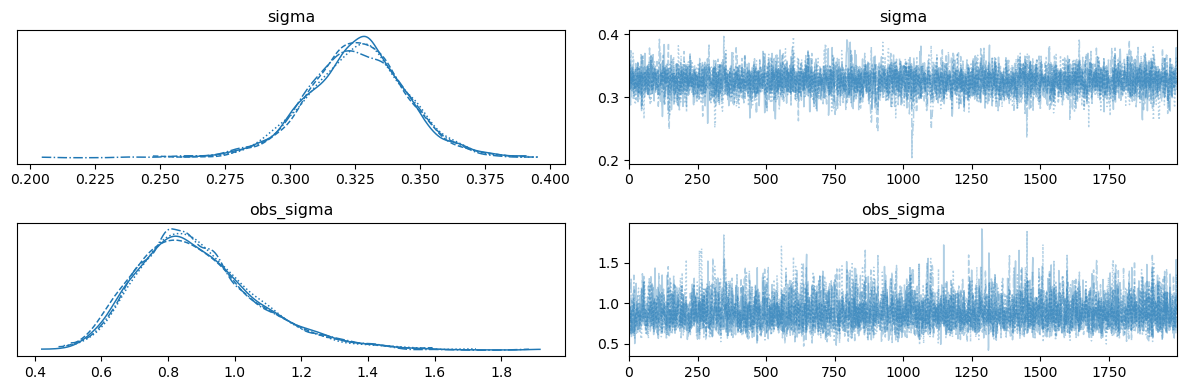


Bayesian estimated volatility: 0.3257 ± 0.0192
Yahoo mean implied volatility (filtered strikes): 0.3170


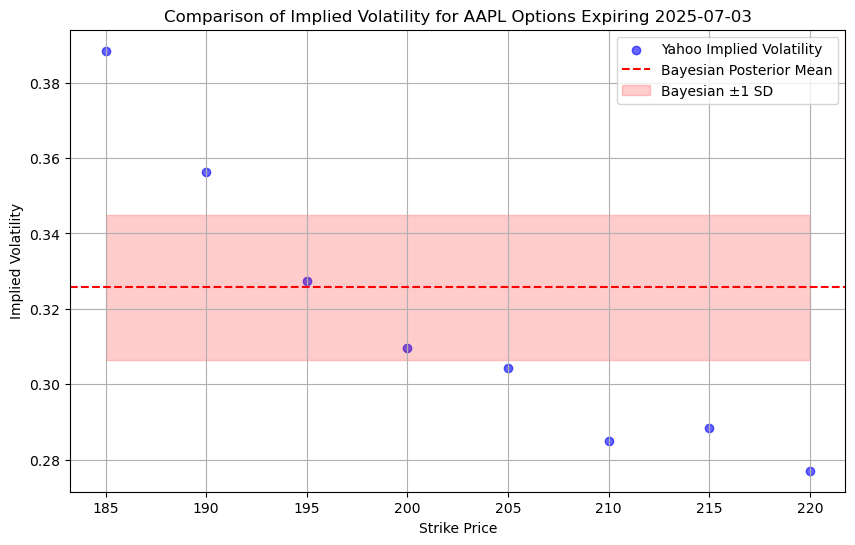

/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_dia

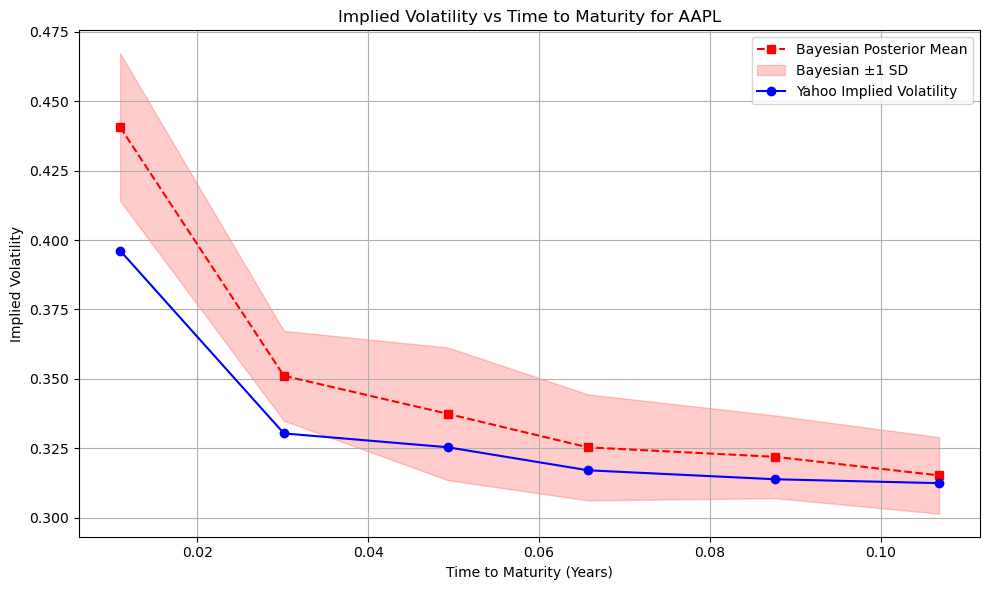

In [31]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
from datetime import datetime


def bayesian_iv_estimation(S, K, C_obs, r, T, draws=1000, tune=1000):
    with pm.Model() as model:
        K_data = pm.ConstantData("K_data", K)

        sigma = pm.HalfNormal("sigma", sigma=1.0)
        obs_sigma = pm.HalfNormal("obs_sigma", sigma=0.5)

        def Phi(x):
            return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))

        d1 = (pm.math.log(S / K_data) + (r + 0.5 * sigma**2) * T) / (sigma * pm.math.sqrt(T))
        d2 = d1 - sigma * pm.math.sqrt(T)
        C_model = S * Phi(d1) - K_data * pm.math.exp(-r * T) * Phi(d2)

        pm.Normal("C_obs", mu=C_model, sigma=obs_sigma, observed=C_obs)

        trace = pm.sample(draws=draws, tune=tune, target_accept=0.95,
                          return_inferencedata=True, progressbar=False)

    summary = az.summary(trace, var_names=["sigma"], round_to=4)
    mean_sigma = summary.loc["sigma", "mean"]
    std_sigma = summary.loc["sigma", "sd"]

    return mean_sigma, std_sigma, trace


def implied_volatility_vs_maturity(ticker, max_expiries=6, r=0.01):
    stock = yf.Ticker(ticker)
    expiries = stock.options[:max_expiries]

    bayesian_means = []
    bayesian_stds = []
    yahoo_means = []
    maturities = []

    for expiry in expiries:
        try:
            today = datetime.today()
            T = (datetime.strptime(expiry, "%Y-%m-%d") - today).days / 365.0
            if T <= 0:
                continue

            option_chain = stock.option_chain(expiry)
            calls = option_chain.calls
            S = stock.history(period="1d")["Close"].iloc[-1]

            calls_filtered = calls[(calls["strike"] > S * 0.9) & (calls["strike"] < S * 1.1)]
            if calls_filtered.empty:
                continue

            K = calls_filtered["strike"].values
            C_obs = np.maximum(calls_filtered["lastPrice"].values, 0.01)
            yahoo_iv = calls_filtered["impliedVolatility"].values

            mean_sigma, std_sigma, _ = bayesian_iv_estimation(S, K, C_obs, r, T, draws=1000, tune=1000)

            maturities.append(T)
            bayesian_means.append(mean_sigma)
            bayesian_stds.append(std_sigma)
            yahoo_means.append(np.mean(yahoo_iv))

        except Exception as e:
            print(f"Skipping expiry {expiry} due to error: {e}")
            continue

    maturities = np.array(maturities)
    bayesian_means = np.array(bayesian_means)
    bayesian_stds = np.array(bayesian_stds)
    yahoo_means = np.array(yahoo_means)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Bayesian posterior mean and uncertainty band
    plt.plot(maturities, bayesian_means, 's--', color='red', label='Bayesian Posterior Mean')
    plt.fill_between(maturities,
                     bayesian_means - bayesian_stds,
                     bayesian_means + bayesian_stds,
                     color='red', alpha=0.2, label='Bayesian ±1 SD')

    # Yahoo IV
    plt.plot(maturities, yahoo_means, 'o-', color='blue', label='Yahoo Implied Volatility')

    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Implied Volatility")
    plt.title(f"Implied Volatility vs Time to Maturity for {ticker}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def implied_volatility_vs_market_data(ticker, expiry_date=None, r=0.01):
    import yfinance as yf
    import numpy as np
    import pymc as pm
    import arviz as az
    import matplotlib.pyplot as plt
    from datetime import datetime

    stock = yf.Ticker(ticker)

    S = stock.history(period="1d")["Close"].iloc[-1]

    expiries = stock.options

    # If expiry_date is None, pick default (e.g., 4th expiry)
    if expiry_date is None:
        expiry = expiries[3]
        print(f"No expiry_date provided. Using default expiry: {expiry}")
    else:
        if expiry_date in expiries:
            expiry = expiry_date
        else:
            print("ERROR: Provided expiry_date is not in available expiries.")
            print("Available expiries are:")
            for e in expiries:
                print(e)
            return None

    today = datetime.today()
    T = (datetime.strptime(expiry, "%Y-%m-%d") - today).days / 365.0
    if T <= 0:
        print(f"WARNING: The expiry date {expiry} has already passed or is today.")
        return None

    option_chain = stock.option_chain(expiry)
    calls = option_chain.calls
    calls_filtered = calls[(calls["strike"] > S * 0.9) & (calls["strike"] < S * 1.1)]

    K = calls_filtered["strike"].values
    C_obs = calls_filtered["lastPrice"].values
    C_obs = np.maximum(C_obs, 0.01)  # avoid zero or negative prices

    yahoo_iv = calls_filtered["impliedVolatility"].values

    # Run Bayesian inference (assuming bayesian_iv_estimation is defined)
    posterior_mean, posterior_std, trace = bayesian_iv_estimation(S, K, C_obs, r, T, draws=2000, tune=2000)

    # Plot trace
    az.plot_trace(trace, var_names=["sigma", "obs_sigma"])
    plt.tight_layout()
    plt.show()

    print(f"\nBayesian estimated volatility: {posterior_mean:.4f} ± {posterior_std:.4f}")
    print(f"Yahoo mean implied volatility (filtered strikes): {np.mean(yahoo_iv):.4f}")

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(K, yahoo_iv, color='blue', label='Yahoo Implied Volatility', alpha=0.6)
    plt.axhline(posterior_mean, color='red', linestyle='--', label='Bayesian Posterior Mean')
    plt.fill_between(K,
                     posterior_mean - posterior_std,
                     posterior_mean + posterior_std,
                     color='red', alpha=0.2, label='Bayesian ±1 SD')

    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title(f"Comparison of Implied Volatility for {ticker} Options Expiring {expiry}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "posterior_mean": posterior_mean,
        "posterior_std": posterior_std,
        "yahoo_iv_mean": np.mean(yahoo_iv),
        "expiry": expiry
    }



ticker = "AAPL"
r = 0.01
implied_volatility_vs_market_data(ticker, expiry_date="2025-07-03", r=0.01)
implied_volatility_vs_maturity("AAPL", max_expiries=6, r=0.01)

